In [1]:
import numpy as np

In [9]:
from tqdm import tqdm as tqdm

In [10]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def blr(y, F, mu_0, Sigma_0, a_0, b_0, n_draws=1):
    n = y.shape[0]
    p = mu_0.shape[0]
    mu_post = np.matmul(np.linalg.inv(np.matmul(np.transpose(F), F) + Sigma_0),
                        np.matmul(Sigma_0, mu_0) + np.matmul(np.transpose(F), y))
    Sigma_post = np.matmul(np.transpose(F), F) + Sigma_0
    a_post = a_0 + n / 2
    b_post = b_0 + 0.5 * (np.matmul(np.transpose(y), y) + 
                          np.matmul(np.matmul(np.transpose(mu_0), Sigma_0), mu_0) - 
                          np.matmul(np.matmul(np.transpose(mu_post), Sigma_post), mu_post))
    beta = np.empty([n_draws, p])
    sigma2_eps = 1 / np.random.gamma(a_post, 1 / b_post, n_draws)
    
    for i in range(n_draws):
        beta[i, :] = np.random.multivariate_normal(mu_post, sigma2_eps[i] * np.linalg.inv(Sigma_post))
    return beta, sigma2_eps


def blr_mv(y, F, mu_0, Sigma_0, a_0, b_0):
    q = y.shape[1]
    r = F.shape[1]
    beta_est = np.empty([r, q])
    sigma2_eps_est = np.empty(q)
    for j in range(q):
        results = blr(y[:, j], F, mu_0, Sigma_0, a_0, b_0)
        beta_est[:, j] = results[0]
        sigma2_eps_est[j] = results[1]
    return beta_est, sigma2_eps_est


def sample_regression_posterior(Y, F, loading_prior_params=[0, 1], variance_prior_params=[1, 1]):
    r = F.shape[1]
    mu_0 = np.repeat(loading_prior_params[0], r)  # prior for regression coefficients
    Sigma_0 = np.diag(np.repeat(loading_prior_params[1], r)) 
    loading, variance = blr_mv(Y, F, mu_0, Sigma_0, variance_prior_params[0], variance_prior_params[1])
    return loading, variance

In [3]:
def build_covariance_blocks(F_covariance_list, loading_matrix, Y_variance):
    """
    Build covariance matrix for long vector of all columns of Y stacked together.
    
    Args
        F_covariance_list: (list) of [t, t] covariance matrices
        loading_matrix: (numpy array) [r, q] linear transformation between F and Y
        Y_sigma_list: (numpy array) [q] variance parameters for columns of Y
    """
    r = len(F_covariance_list)
    t = F_covariance_list[0].shape[0]
    q = loading_matrix.shape[1]
    block_YY = np.zeros((q * t, q * t))
    # covariance for columns of F
    block_FF_rows = []
    for i in range(r):
        current_row = np.zeros((t, r * t))
        current_row[:, (i * t):(i * t + t)] = F_covariance_list[i]
        block_FF_rows.append(current_row)
    block_FF = np.vstack(block_FF_rows)
    # covariance between columns of F and columns of Y
    block_FY_rows = []
    for i in range(r):
        current_row = np.zeros((t, q * t))
        for j in range(q):
            current_row[:, (j * t):(j * t + t)] = loading_matrix[i, j] * F_covariance_list[i]
        block_FY_rows.append(current_row)
    block_FY = np.vstack(block_FY_rows)
    block_YF = np.transpose(block_FY)
    # covariance between columns of Y
    block_YY_rows = []
    for i in range(q):
        current_row = np.zeros((t, q * t))
        for j in range(q):
            for k in range(r):
                current_row[:, (j * t):(j * t + t)] += F_covariance_list[k] * loading_matrix[k, i] * loading_matrix[k, j]
            if i == j:
                current_row[:, (j * t):(j * t + t)] += np.eye(t) * Y_variance[i]  # diagonal variance
        block_YY_rows.append(current_row)
    block_YY = np.vstack(block_YY_rows)
    return block_FF, block_FY, block_YF, block_YY


def sample_conditional_F(Y, blocks, debug=False):
    """
    Sample from conditional distribution of F given everything else.
    
    Args
        Y: (numpy array) [t, q] observed multivariate time series
        block_FF, block_FY, block_YF, block_YY: (numpy array) blocks in the covariance of joint distribution
    """
    block_FF, block_FY, block_YF, block_YY = blocks
    t, q = Y.shape
    r = int(block_FF.shape[0] / t)
    Y_stack = np.transpose(Y).reshape(t * q)  # stack columns of Y
    block_YY_inverse = np.linalg.inv(block_YY)
    prod = np.matmul(block_FY, block_YY_inverse)
    mu = np.matmul(prod, Y_stack)
    covariance = block_FF - np.matmul(prod, block_YF)
    F_stack = np.random.multivariate_normal(mu, covariance)
    F_sample = np.transpose(F_stack.reshape((r, t)))  # de-stack columns of F
    if debug:
        return F_sample, covariance
    else:
        return F_sample

In [4]:
from scipy.stats import gamma, cauchy, multivariate_normal, norm

In [5]:
def l_gamma_prior(l, a, b):
    return gamma.pdf(l, a=a, scale=1/b)


def s_half_cauchy_prior(s, scale):
    return 2 * cauchy.pdf(s, loc=0, scale=scale)


def kernel_covariance(x, l, s, noise=1e-6):
    t = x.shape[0]
    cov_sample = np.zeros((t, t))
    for i in range(t):
        for j in range(t):
            cov_sample[i, j] = s ** 2 * np.exp(-(x[i] - x[j]) ** 2 / (2 * l ** 2))
    cov_sample += np.eye(t) * noise
    return cov_sample


def reshape_latent_curves(F, n, t):
    r = F.shape[1]
    F_curves_list = []
    for j in range(r):
        F_curves = np.zeros((t, n))
        for i in range(n):
            F_curves[:, i] = F[(i * t):(i * t + t), j]
        F_curves_list.append(F_curves)
    return F_curves_list

In [57]:
def accept_reject(accept_prob):
    u = np.random.uniform(low=0.0, high=1.0, size=1)
    return u < accept_prob


def gp_marginal_likelihood(y, x, l, s):
    t = y.shape[0]
    mu = np.repeat(0, t)
    cov = kernel_covariance(x, l, s)
    return multivariate_normal.pdf(y, mu, cov)


def propose(current, std):
    value = -1
    while value < 0:
        value = np.random.normal(loc=current, scale=std, size=1)
    return value


def calculate_p(l, s, Y, x, prior_params):
    a, b, scale = prior_params
    prior = l_gamma_prior(l, a, b)  # * s_half_cauchy_prior(s, scale)
    loglik = 0.0
    for j in range(Y.shape[1]):
        loglik += np.log(gp_marginal_likelihood(Y[:, j], x, l, s)) # independent observations
    return np.log(prior) + loglik


def metropolis_update(l, s, p, Y, x, prior_params, proposal_scales):
    l_new = propose(l, proposal_scales[0])
    s_new = 1.0
    #s_new = propose(s, proposal_scales[1])

    p_new = calculate_p(l_new, s_new, Y, x, prior_params)
    
    if accept_reject(np.exp(p_new - p)):
        return l_new, s_new, p_new
    else:
        return l, s, p


def metropolis_sample(n_iter, Y, x, prior_params=[10, 0.1, 0.5], proposal_scales=[0.2, 0.2]):
    l = propose(10.0, proposal_scales[0])
    #s = propose(1, proposal_scales[1])
    s = 1.0
    p = calculate_p(l, s, Y, x, prior_params)
    
    l_trace = []
    s_trace = []
    for i in range(n_iter):
        l, s, p = metropolis_update(l, s, p, Y, x, prior_params, proposal_scales)
        l_trace.append(l)
        s_trace.append(s)
        
    return l_trace, s_trace

In [45]:
class FactorGP:

    def __init__(self, dims, mu_var=[0, 1], inverse_gamma=[1, 1], gamma=[10, 1], F=None):
        n, t, q, r = dims
        self.dims = dims
        self.x = np.linspace(1, t, t)
        self.loading_prior_params = mu_var
        self.variance_prior_params = inverse_gamma
        self.length_prior_params = gamma
        #self.kernel_type = 'default'
        self.loading, self.variance, self.theta = self.__initiate_params(dims, mu_var, inverse_gamma, gamma)
        self.F = F


    def __initiate_params(self, dims, mu_var, inverse_gamma, gamma):
        n, t, q, r = dims
        loading = np.random.normal(mu_var[0], np.sqrt(mu_var[1]), [r, q])
        variance = np.random.normal(0, 0.5, q) ** 2  # ad-hoc
        theta = np.repeat(gamma[0] * gamma[1], r)
        return loading, variance, theta


    def conditional_latent(self, Y):
        n, t, q, r = self.dims
        covs = []
        for l in self.theta:
            covs.append(kernel_covariance(self.x, l, 1.0))
        blocks = build_covariance_blocks(covs, self.loading, self.variance)
        F = np.zeros((n * t, r))
        for i in range(n):
            F[(i * t):(i * t + t), :] = sample_conditional_F(Y[(i * t):(i * t + t), :], blocks)
        self.F = F
    

    def predict(self):
        return np.matmul(self.F, self.loading)

In [87]:
def gibbs_update(Y, model, chain_size=50, proposal_std=0.5):
    n, t, q, r = model.dims
    if model.F is None:
        model.conditional_latent(Y)
    F = model.F
    loading, variance = sample_regression_posterior(Y, F, model.loading_prior_params, model.variance_prior_params)
    F_curves_list = reshape_latent_curves(F, n, t)
    theta = np.zeros(r)
    traces = np.zeros((r, chain_size))
    for i, F_curves in enumerate(F_curves_list):
        l_trace, s_trace = metropolis_sample(chain_size, F_curves, model.x, 
                                             prior_params=[model.length_prior_params[0], model.length_prior_params[1], 0.5], 
                                             proposal_scales=[proposal_std, 0.5])
        theta[i] = l_trace[-1]
        traces[i, :] = l_trace
    return F, loading, variance, theta, traces

In [88]:
def run_gibbs(Y, model, n_steps, chain_size, proposal_std):
    n, t, q, r = model.dims
    F_sample = np.zeros((n_steps, n * t, r))
    loading_sample = np.zeros((n_steps, r, q))
    variance_sample = np.zeros((n_steps, q))
    theta_sample = np.zeros((n_steps, r))
    for i in tqdm(range(n_steps)):
        F, loading, variance, theta, _ = gibbs_update(Y, model, chain_size, proposal_std)
        F_sample[i, :, :] = F
        loading_sample[i, :, :] = loading 
        variance_sample[i, :] = variance
        theta_sample[i, :] = theta
        # update model parameters and latent factors
        model.loading = loading
        model.variance = variance
        model.theta = theta
        model.conditional_latent(Y)
    return F_sample, loading_sample, variance_sample, theta_sample

In [13]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

In [19]:
gp = GaussianProcessRegressor(kernel=RBF(length_scale=10))

In [20]:
x = np.linspace(1, 50, 50)
curves = gp.sample_y(x.reshape((50, 1)), 4)

In [21]:
F = np.zeros((100, 2))  # 2 epochs x 50 time points x 2 factors
for i in range(2):
    for j in range(2):
        F[(i * 50):(i * 50 + 50), j] = curves[:, (i * 2 + j)]

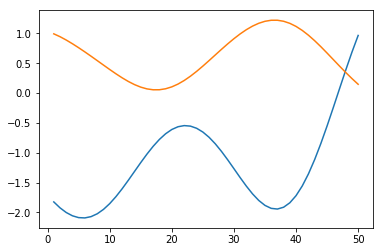

In [24]:
for j in range(2):
    plt.plot(x, F[:50, j])

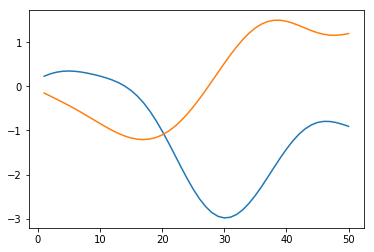

In [25]:
for j in range(2):
    plt.plot(x, F[50:, j])

In [26]:
loading = np.random.normal(0, 1, [2, 6])
Y_true = np.matmul(F, loading)
Y = Y_true + np.random.normal(0, 0.5, [100, 6])

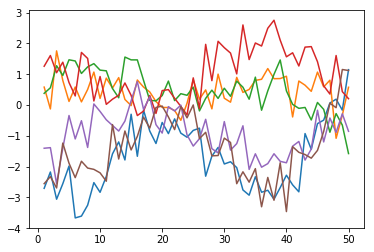

In [27]:
for j in range(6):
    plt.plot(x, Y[:50, j])
plt.show()

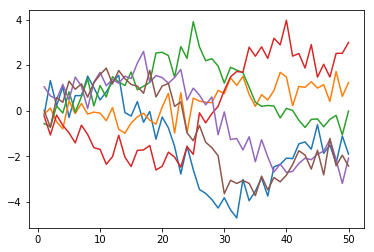

In [28]:
for j in range(6):
    plt.plot(x, Y[50:, j])
plt.show()

In [70]:
dims = [2, 50, 6, 2]  # n, t, q, r
model = FactorGP(dims)

In [71]:
model.conditional_latent(Y)

In [72]:
F = model.F

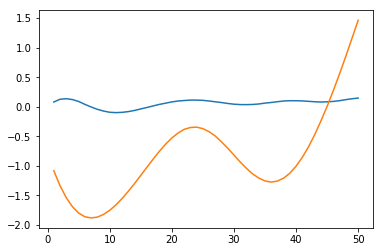

In [73]:
for j in range(2):
    plt.plot(x, F0[:50, j])
plt.show()

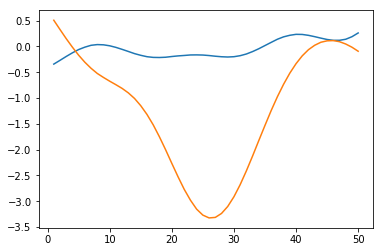

In [74]:
for j in range(2):
    plt.plot(x, F0[50:, j])
plt.show()

In [64]:
F, loading, variance, theta, traces = gibbs_update(Y, model, 50, 1.0)

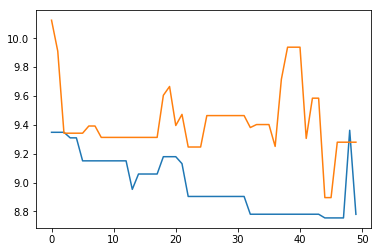

In [69]:
plt.plot(traces[0, :])
plt.plot(traces[1, :])
plt.show()

In [78]:
F_sample, loading_sample, variance_sample, theta_sample = run_gibbs(Y, model, 10, 50, 0.5)

100%|██████████| 10/10 [00:39<00:00,  3.86s/it]


In [79]:
print(F_sample.shape)

(10, 100, 2)


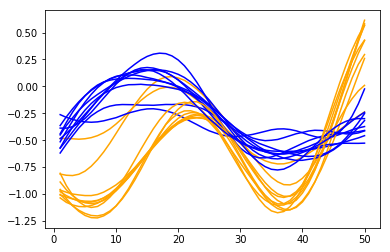

In [81]:
for i in range(10):
    plt.plot(x, F_sample[i, :50, 0], color='orange')
    plt.plot(x, F_sample[i, :50, 1], color='blue')
plt.show()

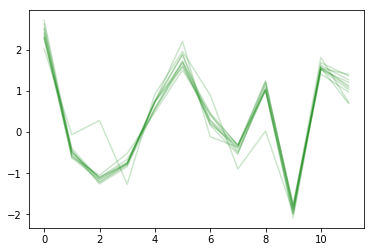

In [83]:
for i in range(10):
    plt.plot(loading_sample[i].flatten(), alpha=0.2, color='green')
plt.show()

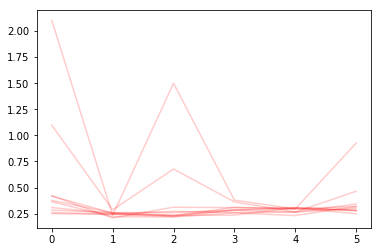

In [84]:
for i in range(10):
    plt.plot(variance_sample[i], alpha=0.2, color='red')
plt.show()

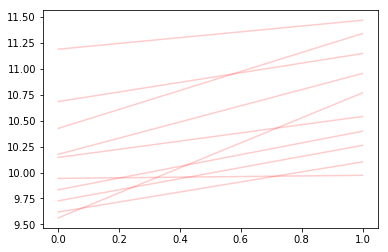

In [85]:
for i in range(10):
    plt.plot(theta_sample[i], alpha=0.2, color='red')
plt.show()